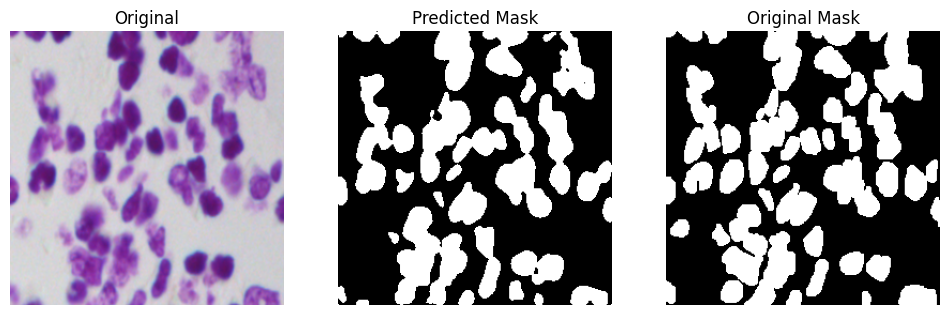

91.8610%


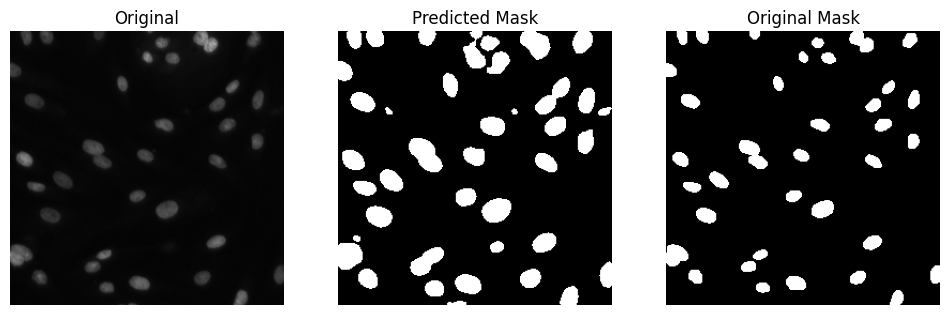

91.4215%


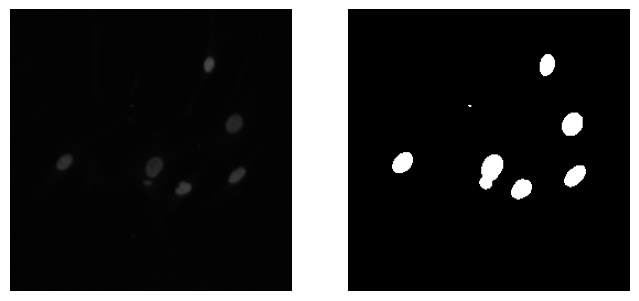

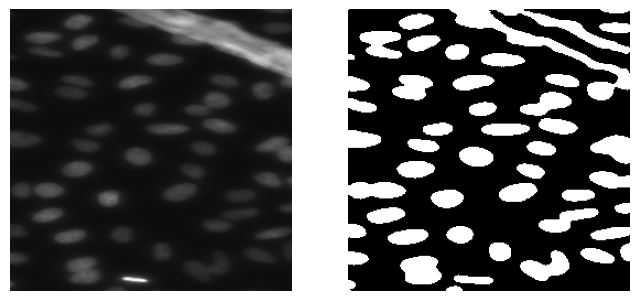

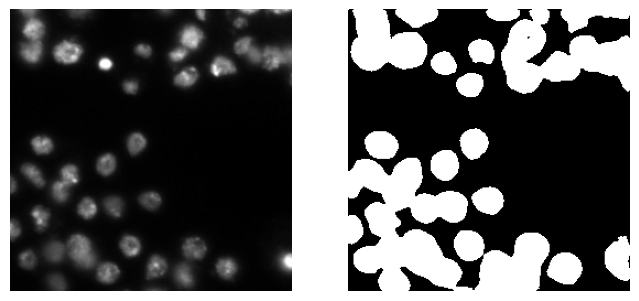

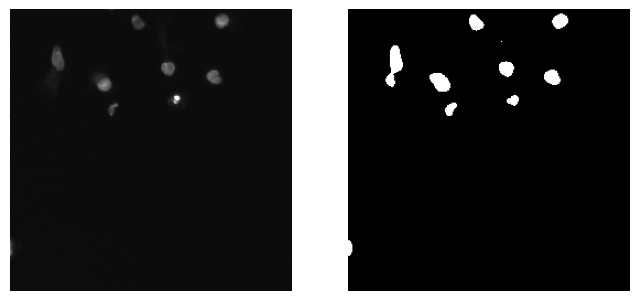

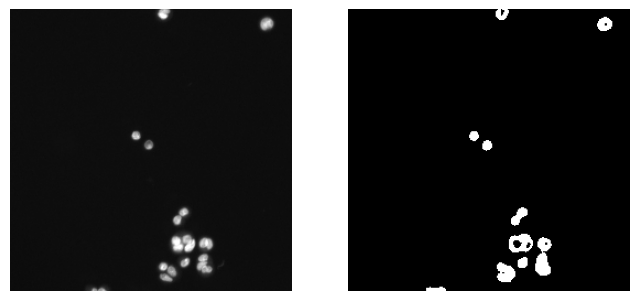

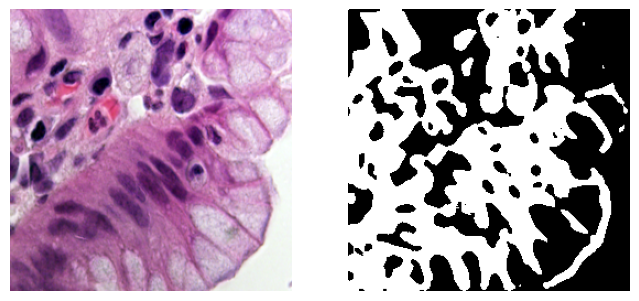

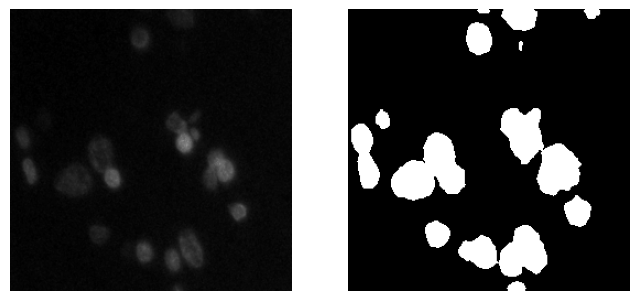

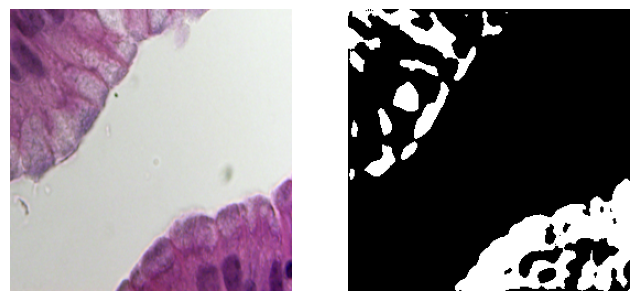

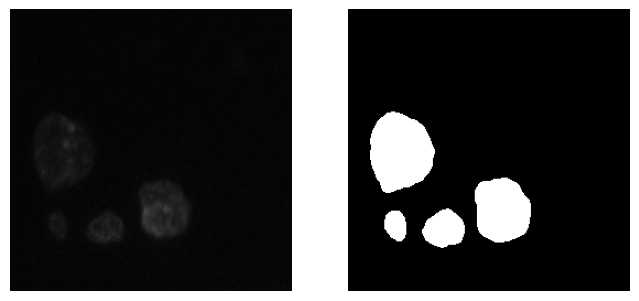

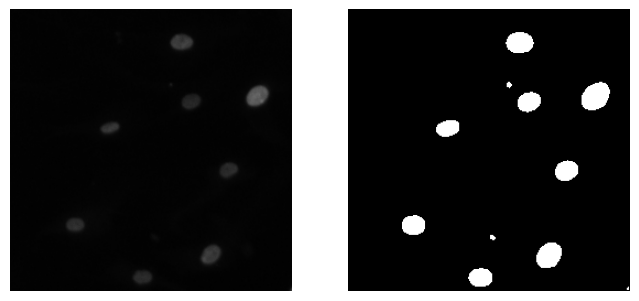

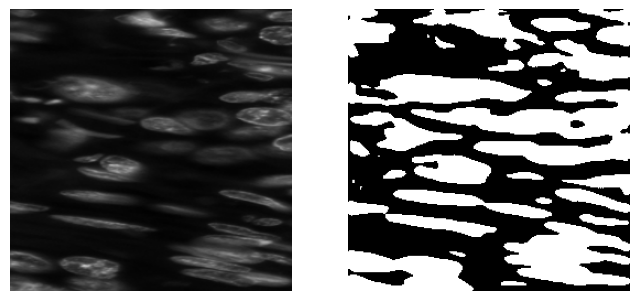

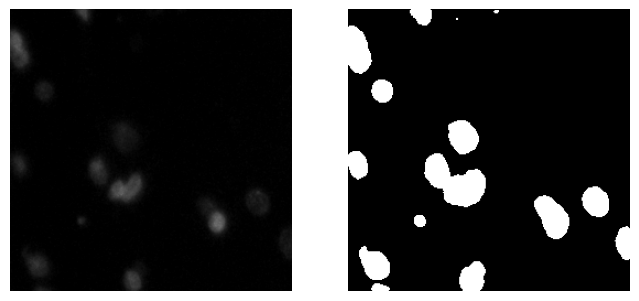

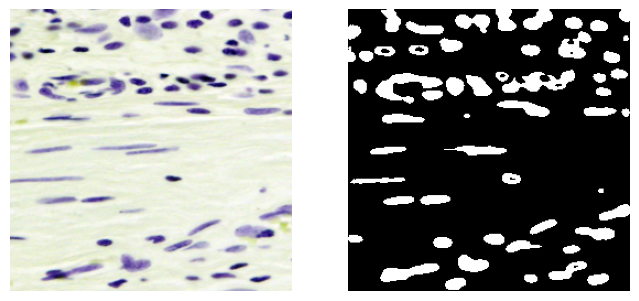

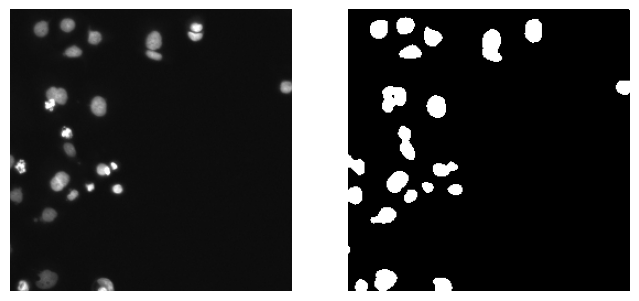

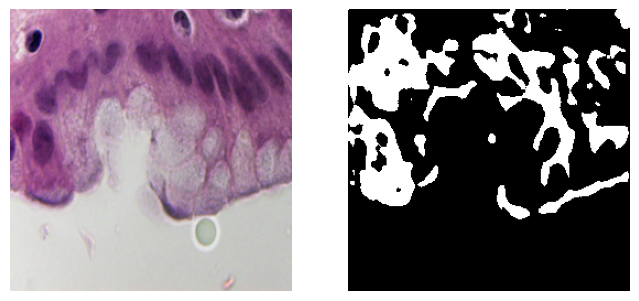

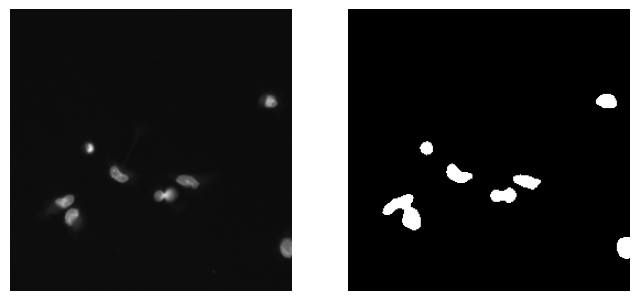

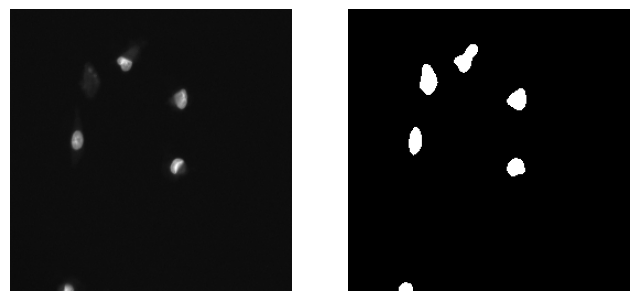

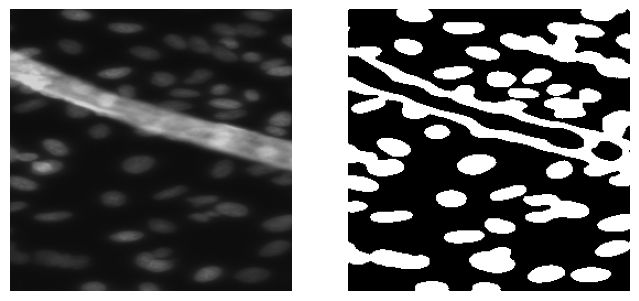

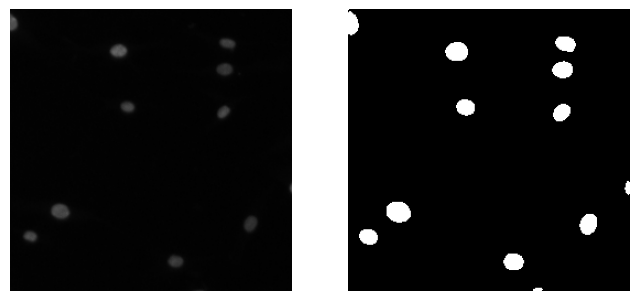

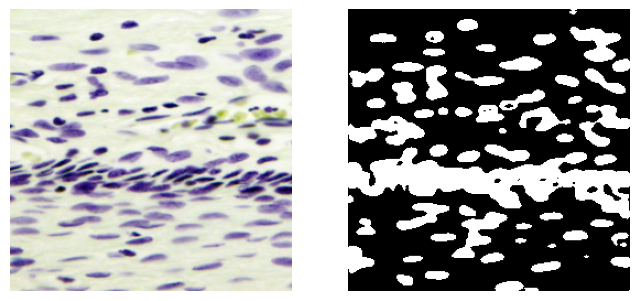

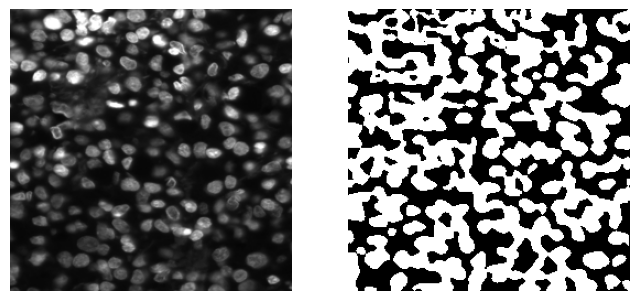

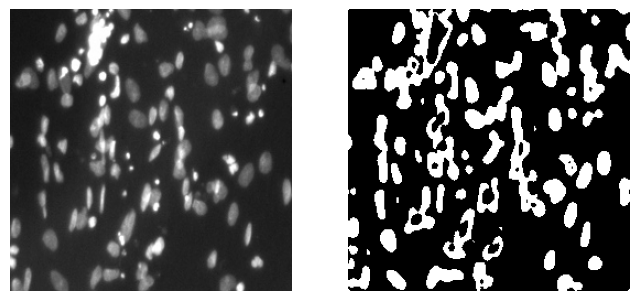

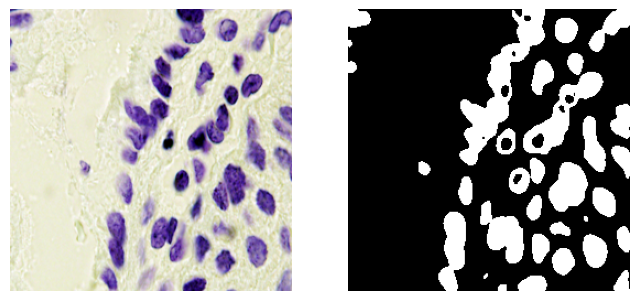

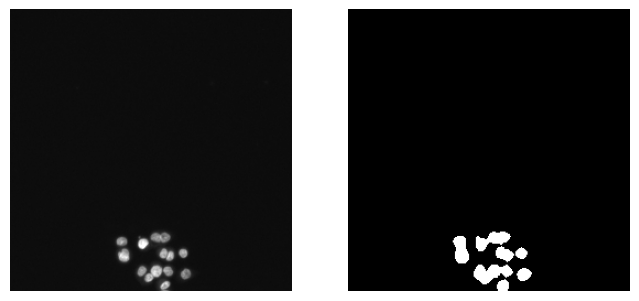

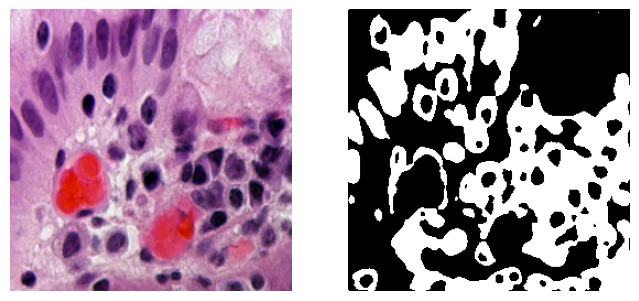

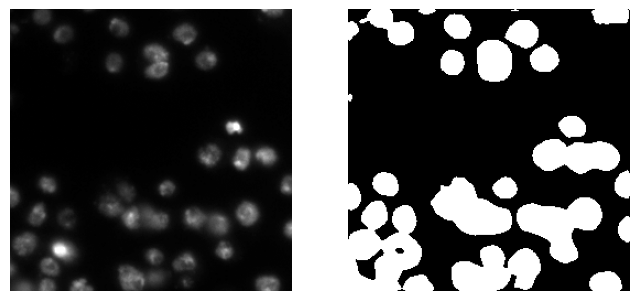

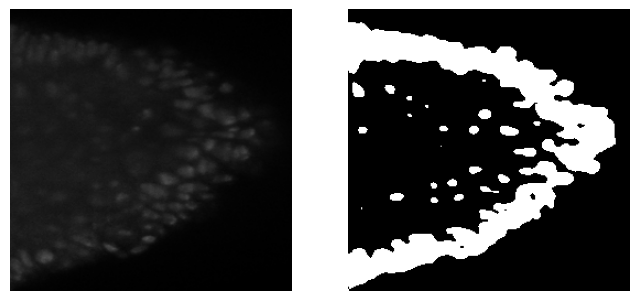

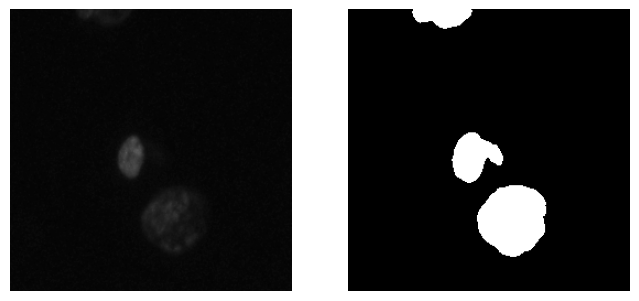

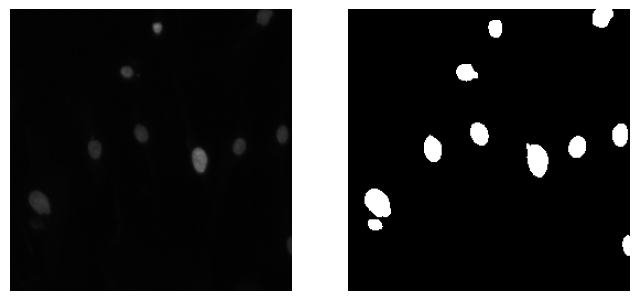

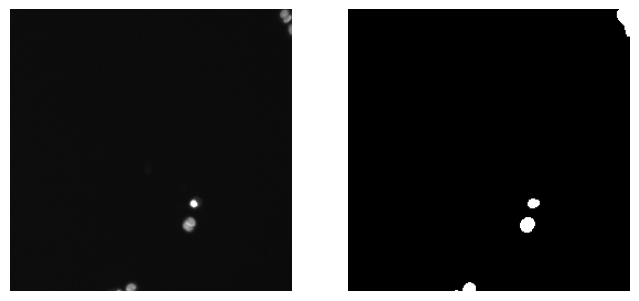

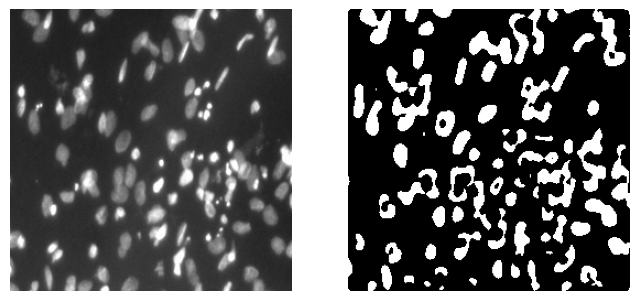

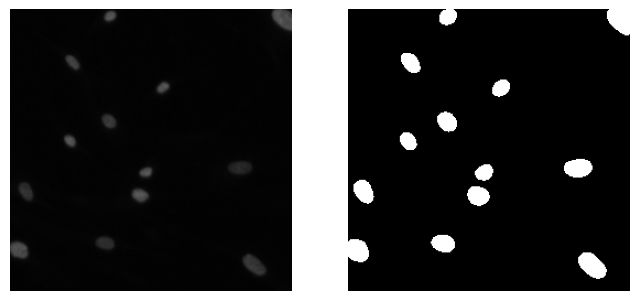

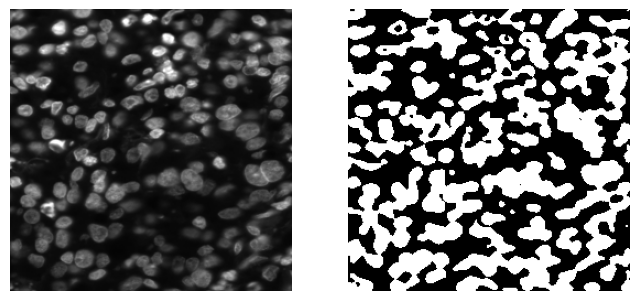

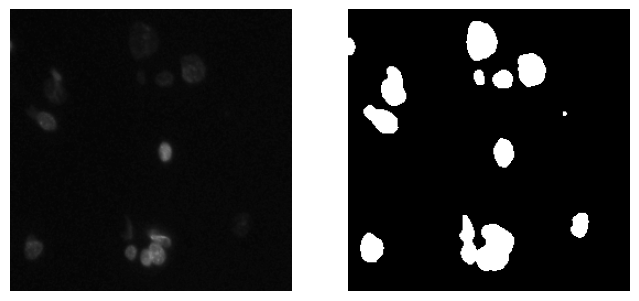

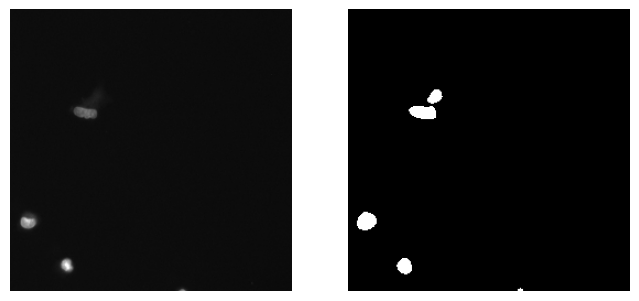

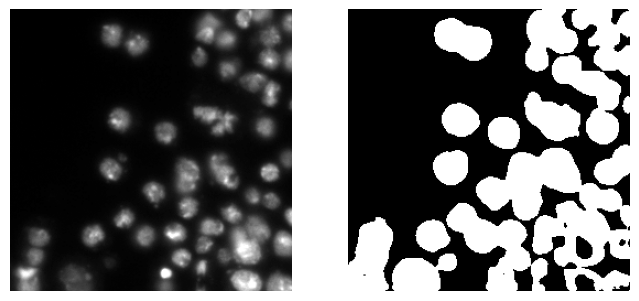

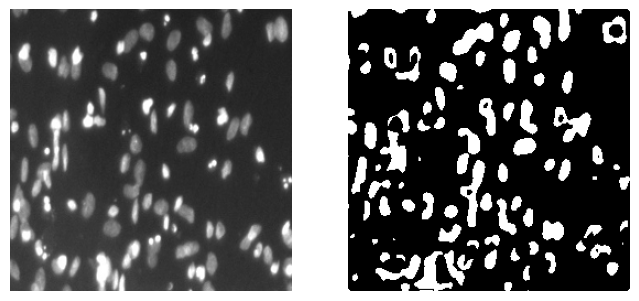

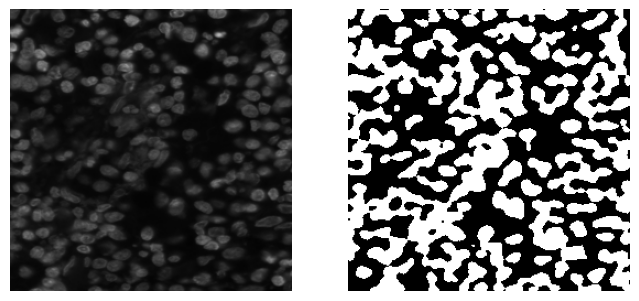

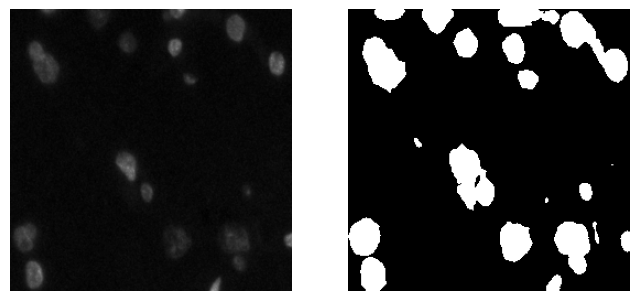

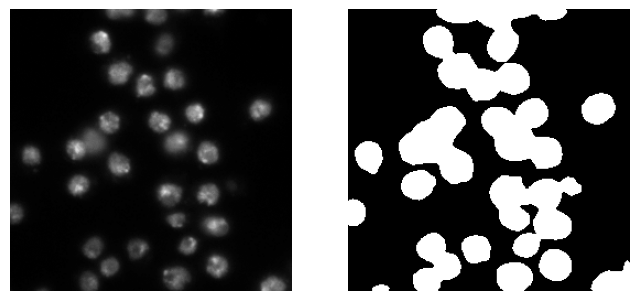

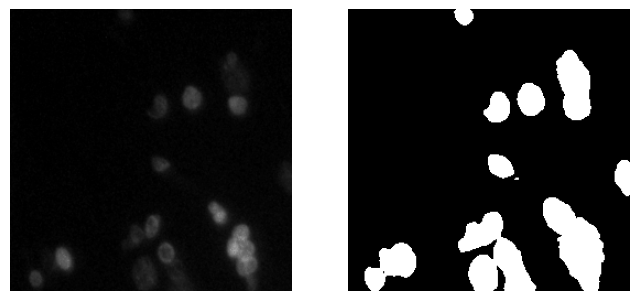

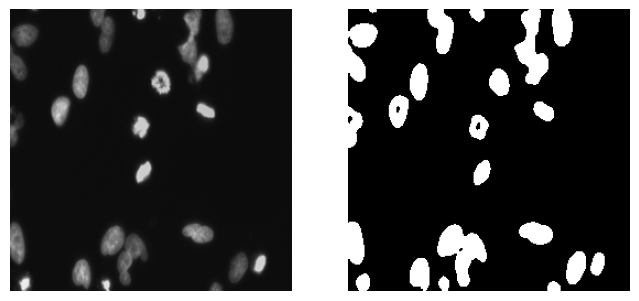

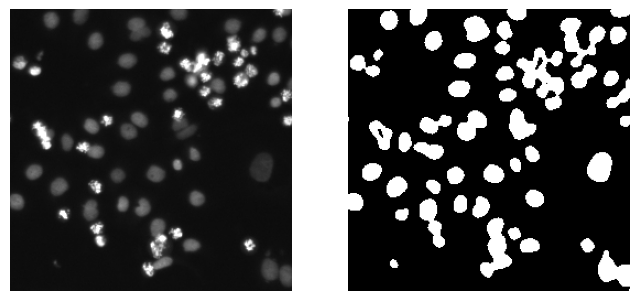

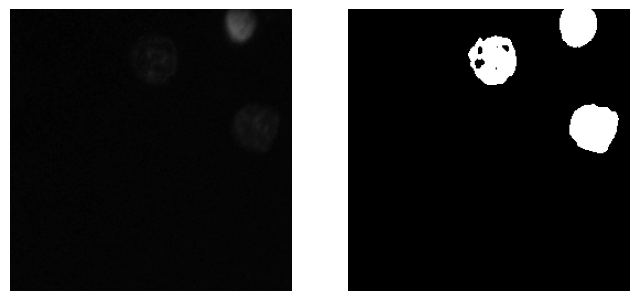

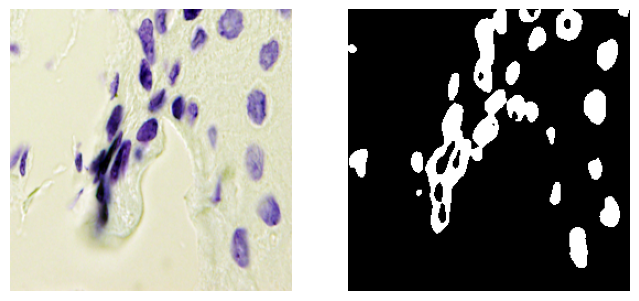

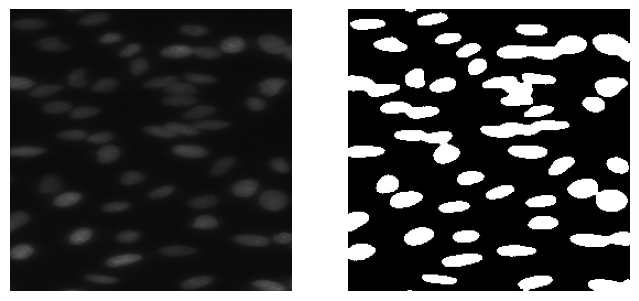

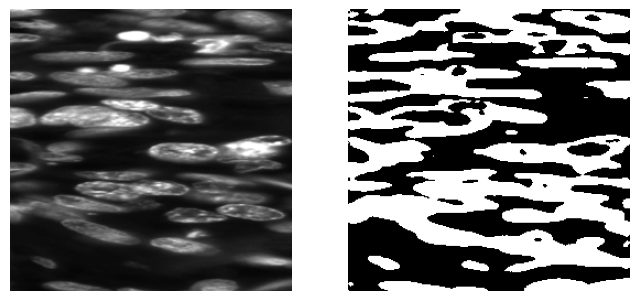

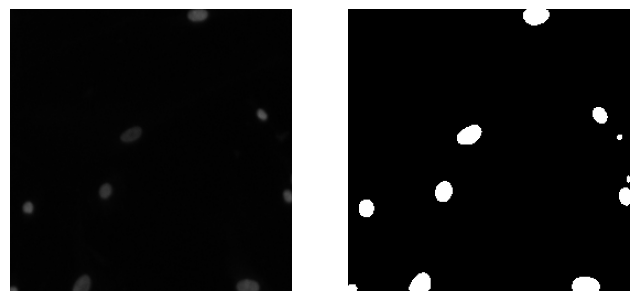

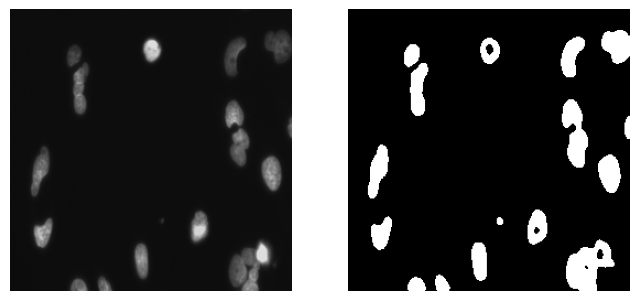

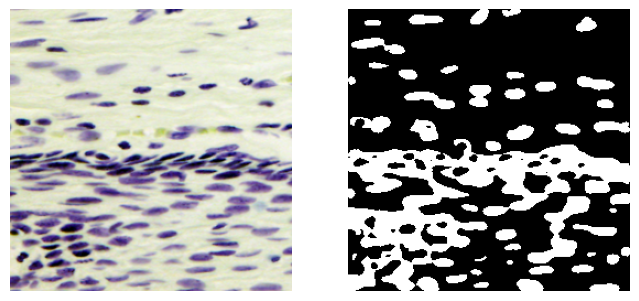

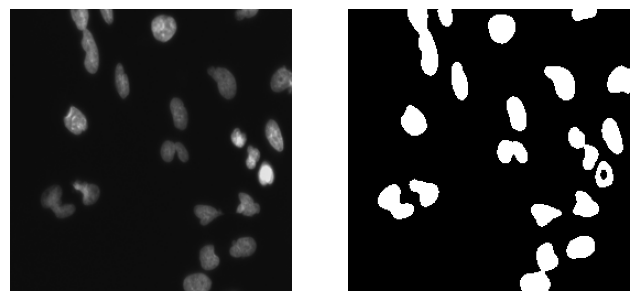

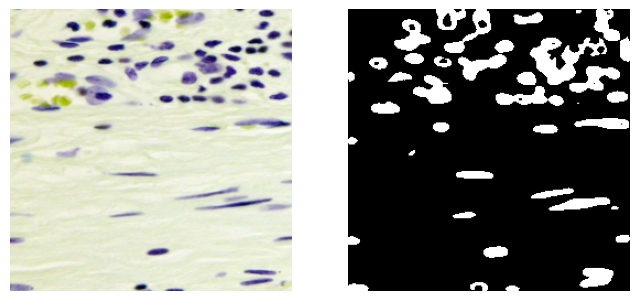

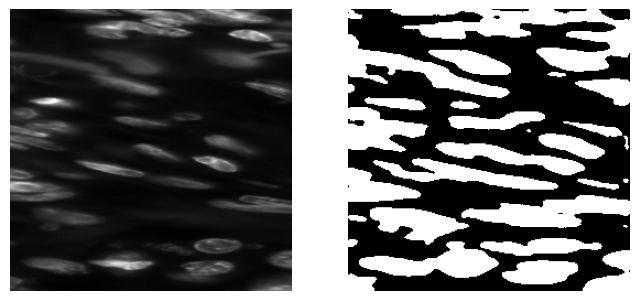

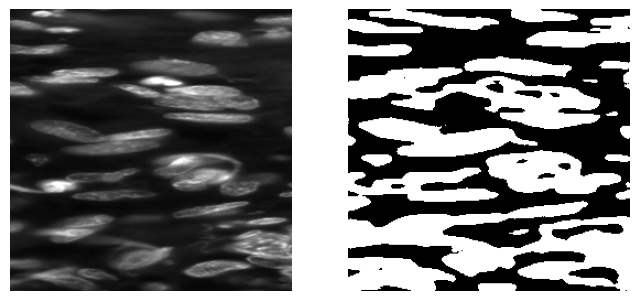

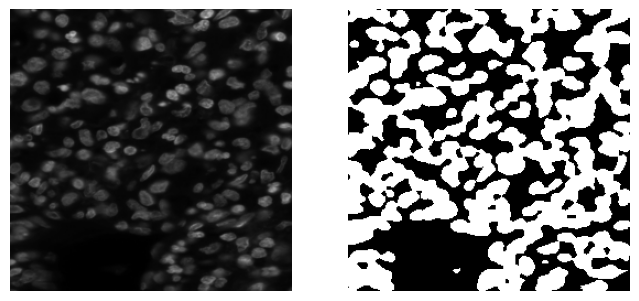

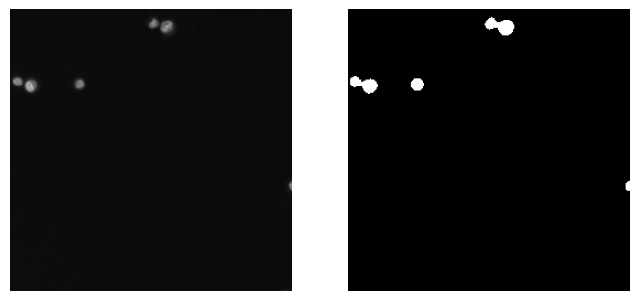

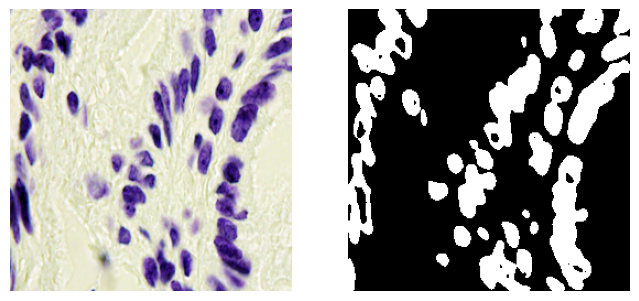

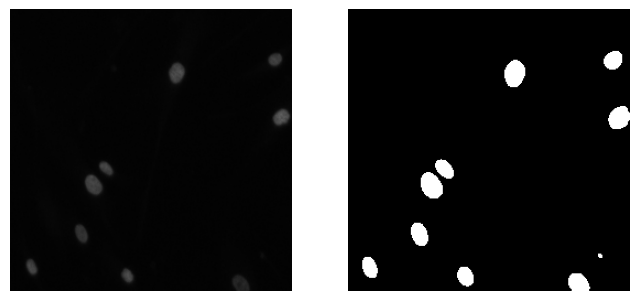

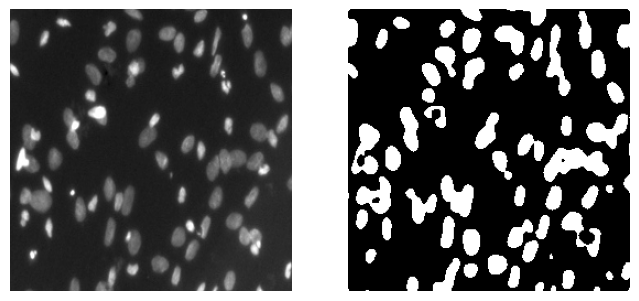

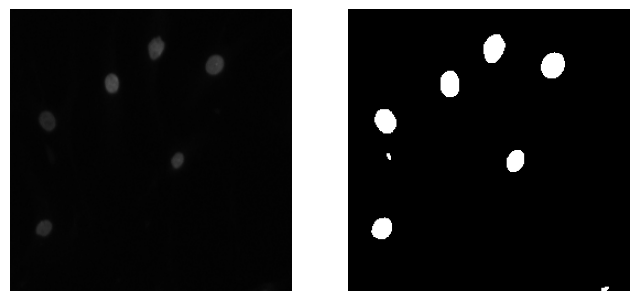

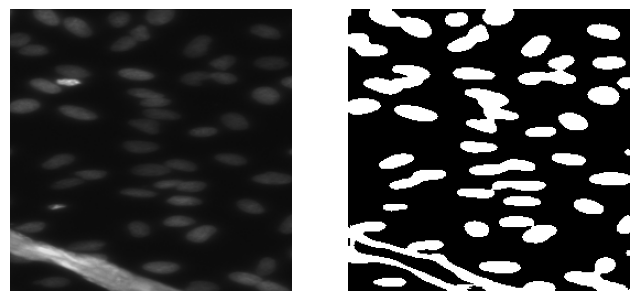

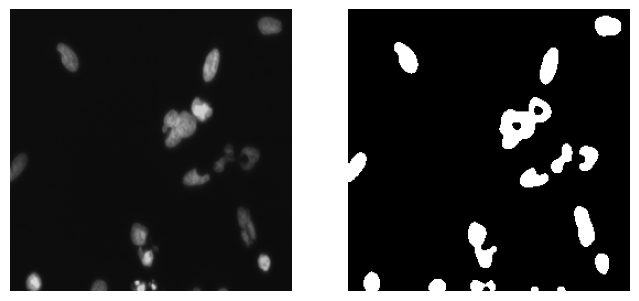

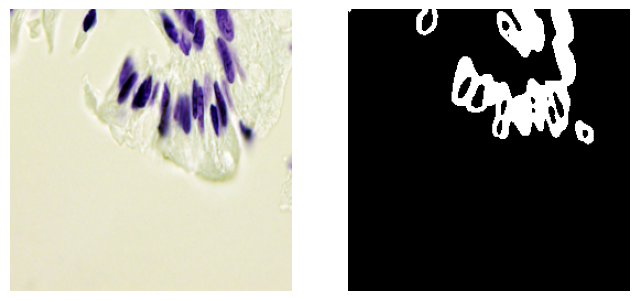

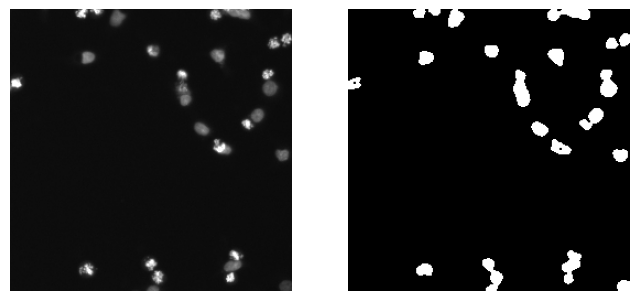

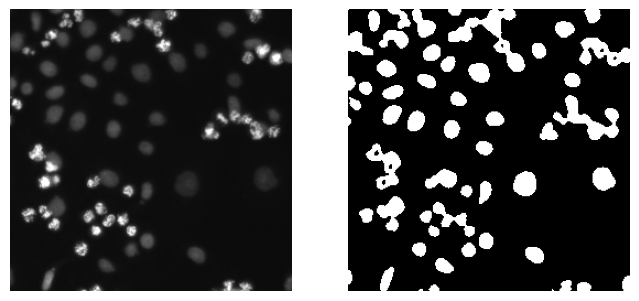

In [14]:
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from unet import UNet
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load("unet.pth", map_location=device))
model.eval()

def predict_image(path):
    img = Image.open(path).convert("RGB").resize((256, 256))
    img_tensor = ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = torch.sigmoid(model(img_tensor))[0][0].cpu().numpy()
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(output > output.max() / 10, cmap="gray")
    plt.axis('off')
    plt.show()
    
def predict_all_in_folder(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(".png"):
                full_path = os.path.join(root, file)
                predict_image(full_path)

def predict_and_compare(example_folder):
    image_dir = os.path.join(example_folder, "images")
    mask_dir = os.path.join(example_folder, "masks")
    image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
    mask_paths = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith(".png")]
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img_tensor = ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = torch.sigmoid(model(img_tensor))[0][0].cpu().numpy()
    pred_mask = (output > output.max() / 10).astype(np.uint8)
    mask = np.zeros((256, 256), dtype=np.uint8)
    for m_path in mask_paths:
        m = Image.open(m_path).resize((256, 256)).convert("L")
        m_bin = (np.array(m) > 0).astype(np.uint8)
        mask = np.maximum(mask, m_bin)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Original Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis('off')
    plt.show()
    accuracy = (pred_mask == mask).sum() / (256 * 256)
    print(f"{accuracy * 100:.4f}%")

predict_and_compare("dataset/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e")
predict_and_compare("dataset/1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5")
predict_all_in_folder("test/")